**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

TODO:

[x] Normalize
    
[v] CenterCrop
    
[v] replace resize with pad
    

In [1]:
import os
import gc
import copy
import cv2
import numpy as np
from tqdm import tqdm

import torchvision.transforms as transforms
from torch.utils.data import Dataset

import warnings
warnings.filterwarnings("ignore")
import torch
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(42)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
np.random.seed(42)

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1]  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }
        sample["image"] = (sample["image"] / 255.0).astype(np.float32)

        sample['image'] = self.transform(sample['image']).float()
        sample['mask'] = self.transform(sample['mask']).float()
        sample['mask'] = (sample['mask'] > 0).float()
        return sample

In [3]:
X_train_val = get_paths("data/train/images")
y_train_val = get_paths("data/train/gt")

X_test = get_paths("data/test/images")
y_test = get_paths("data/test/gt")

transform = transforms.Compose([
    # transforms.Normalize(total_mean, total_std)
    transforms.ToTensor(),
    transforms.Resize((512,512))
])

In [4]:
# placeholders
psum    = torch.tensor([0.0])
psum_sq = torch.tensor([0.0])

# loop through images
for im_name in tqdm(X_train_val):
    inputs = cv2.imread(im_name)[:,:,::-1] / 255.0
    psum    += np.sum(inputs, axis    = (0, 1))
    psum_sq += np.sum((inputs ** 2), axis = (0, 1))
    
# pixel count
count = len(X_train_val) * 370 * 370

# mean and STD
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('Training data stats:')
print('- mean: ', total_mean)
print('- std:  ', total_std)

100%|██████████| 648/648 [00:05<00:00, 115.16it/s]

Training data stats:
- mean:  tensor([0.3634, 0.3927, 0.3818], dtype=torch.float64)
- std:   tensor([0.2900, 0.3088, 0.3262], dtype=torch.float64)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                  y_train_val, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  shuffle=True)

In [6]:
test_dataset = RoadDataset(X_test, y_test, transform)

torch.Size([1, 512, 512])


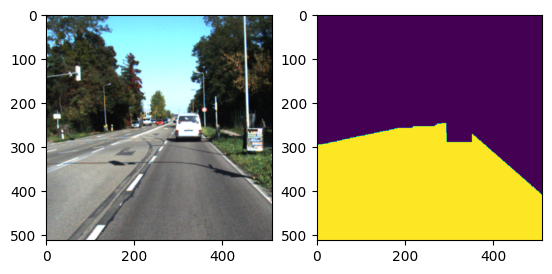

In [7]:
sample = test_dataset[110]
image = sample['image']
mask = sample['mask']
print(mask.shape)

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0))

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or using dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [8]:
print(f"Dataset length {len(test_dataset)}")

Dataset length 219


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

In [9]:
def calc_iou(prediction, ground_truth):
    EPS = 1.e-10
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return (float(intersection) + EPS) / (union + EPS)

In [10]:
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    images = images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]
    return images

In [11]:
import gc
import glob
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import albumentations as A


In [12]:
class CustomDiceLoss(nn.Module):
    
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, inp, target):
        inp = torch.sigmoid(inp)
        loss = 1 - (2 * torch.sum(inp * target) + self.smooth) / (torch.sum(inp) + torch.sum(target) + self.smooth)
        return loss

dice = CustomDiceLoss()

In [13]:
def double_convolution(in_channels, out_channels):

    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return conv_op


class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(3, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)

        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2, 
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2, 
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2, 
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2, 
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)

        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes, 
            kernel_size=1
        ) 

    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)        
        # *** DO NOT APPLY MAX POOL TO down_9 ***
        
        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))

        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))

        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))

        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))

        out = self.out(x)
        return out

In [14]:
def get_trn_objects(device):

    model = UNet(1)

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    trn_augs = A.Compose([
                            A.GaussNoise(var_limit=0.1, p=0.2),
                            A.ShiftScaleRotate(shift_limit=0.09,
                                               rotate_limit=15,
                                               border_mode=0,
                                               p=0.15),
                            A.HorizontalFlip(p=0.5),
                         ])

    val_augs = A.Compose([
                         ])

    trn_dataset = RoadDataset(X_train, y_train, transform, trn_augs)
    val_dataset = RoadDataset(X_val, y_val, transform, val_augs)

    trn_loader = torch.utils.data.DataLoader(trn_dataset, 
                                             batch_size=8, 
                                             shuffle=True, 
                                             pin_memory=True,
                                             num_workers=64,
                                             prefetch_factor=4)

    val_loader = torch.utils.data.DataLoader(val_dataset, 
                                             batch_size=1, 
                                             shuffle=False, 
                                             pin_memory=True,
                                             num_workers=64,
                                             prefetch_factor=2)

    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=1, 
                                              shuffle=False, 
                                              pin_memory=True,
                                              num_workers=2,
                                              prefetch_factor=2)
    
    loss = CustomDiceLoss()

    return {"model": model,
            "optimizer": optimizer,
            "scheduler": scheduler,
            "trn_loader": trn_loader,
            "val_loader": val_loader,
            "test_loader": test_loader,
            "loss": loss}


def train_epoch(model, 
                train_loader, 
                criterion, 
                scheduler, 
                optimizer,
                device,
                thresh):
    model.train()
    losses = []
    ious = []
    for sample in train_loader:
        images = sample["image"].to(device)
        masks = sample["mask"].to(device)
        optimizer.zero_grad()

        y_pred = model(images)

        y_pred = torch.sigmoid(y_pred)
        loss = criterion(y_pred, masks)
        loss.backward()
        optimizer.step()
       
        y_pred = (y_pred > thresh)
        iou = calc_iou(y_pred.detach().cpu().numpy(), masks.detach().cpu().numpy())
        losses.append(loss.item())
        ious.append(iou)
    torch.cuda.empty_cache()
    gc.collect()
    return np.mean(losses, axis = 0), np.mean(ious, axis = 0)


@torch.no_grad()
def val_epoch(model, 
              dataloader,
              criterion,
              scheduler,
              device,
              thresh):

    model.eval()
    losses = []
    ious = []
    
    for sample in dataloader:
        images = sample["image"].to(device)
        masks = sample["mask"].to(device)
        
        y_pred  = model(images)

        y_pred = torch.sigmoid(y_pred)
        loss = criterion(y_pred, masks)
        
        y_pred = (y_pred > thresh)
        
        iou = calc_iou(masks.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        losses.append(loss.item())
        ious.append(iou)
        
    scheduler.step()
    
    iou  = np.mean(ious, axis=0)
    torch.cuda.empty_cache()
    gc.collect()

    return np.mean(losses, axis=0), np.mean(ious, axis=0)

@torch.no_grad()
def test_model(model, dataloader, criterion, device, thresh):
    model.eval()
    losses = []
    ious = []
    
    for sample in tqdm(dataloader):
        images = sample["image"].to(device)
        masks = sample["mask"].to(device)
        y_pred  = model(images)

        loss = criterion(y_pred, masks)
        
        y_pred = torch.nn.Sigmoid()(y_pred)
        y_pred = (y_pred > thresh)
        
        iou = calc_iou(masks.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        losses.append(loss.item())
        ious.append(iou)
    
    iou  = np.mean(ious, axis=0)
    torch.cuda.empty_cache()
    gc.collect()

    return np.mean(losses, axis=0), np.mean(ious, axis=0)


def train(epochs, model=None):
    best_model = None
    best_iou = -np.inf
    device = torch.device("cuda:2")
    results = {"train": {"loss": [], "iou":[]},
               "val":   {"loss": [], "iou":[]}}
    
    trn_objects = get_trn_objects(device)
    if model:
        trn_objects["model"].load_state_dict(model)
    for i in tqdm(range(epochs)):
        trn_loss, trn_iou = train_epoch(trn_objects["model"], 
                                        trn_objects["trn_loader"],
                                        trn_objects["loss"], 
                                        trn_objects["scheduler"], 
                                        trn_objects["optimizer"], 
                                        device,
                                        0.5)
        
        val_loss, val_iou = val_epoch(trn_objects["model"], 
                                      trn_objects["trn_loader"], 
                                      trn_objects["loss"], 
                                      trn_objects["scheduler"], 
                                      device,
                                      0.5)
        
        if val_iou > best_iou:
            best_model = copy.deepcopy(trn_objects["model"].state_dict())
            best_iou = val_iou

        results["train"]["loss"].append(trn_loss)
        results["train"]["iou"].append(trn_iou)
        results["val"]["loss"].append(val_loss)
        results["val"]["iou"].append(val_iou)
        
    trn_objects["model"].load_state_dict(best_model)
    
    results["res_loss"], results["res_iou"] = test_model(trn_objects["model"], 
                                                         trn_objects["test_loader"], 
                                                         trn_objects["loss"], 
                                                         device,
                                                         0.5)
    return results, trn_objects["model"]

In [15]:
torch.cuda.empty_cache()

100%|██████████| 219/219 [00:05<00:00, 43.50it/s]


0.28501443585304365 0.6608397940957704


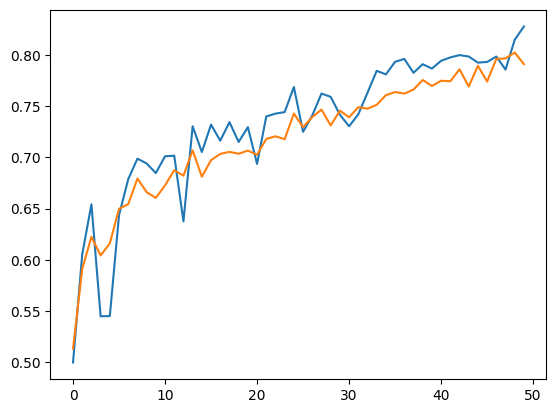

In [50]:
results, model = train(50)
plt.plot(list(range(len(results["val"]["iou"]))), results["val"]["iou"])
plt.plot(list(range(len(results["train"]["iou"]))), results["train"]["iou"])
print(results["res_loss"], results["res_iou"])

100%|██████████| 219/219 [00:04<00:00, 43.94it/s]


0.24330035981522302 0.6857773011583963


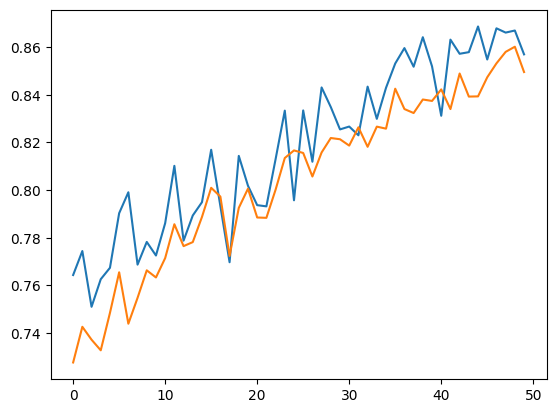

In [53]:
results, model = train(50, model.state_dict())
plt.plot(list(range(len(results["val"]["iou"]))), results["val"]["iou"])
plt.plot(list(range(len(results["train"]["iou"]))), results["train"]["iou"])
print(results["res_loss"], results["res_iou"])

100%|██████████| 219/219 [00:05<00:00, 41.27it/s]


0.20836910374088374 0.7186396990634699


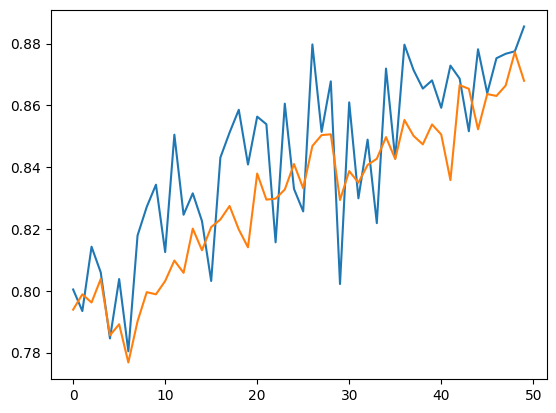

In [56]:
results, model = train(50, model.state_dict())
plt.plot(list(range(len(results["val"]["iou"]))), results["val"]["iou"])
plt.plot(list(range(len(results["train"]["iou"]))), results["train"]["iou"])
print(results["res_loss"], results["res_iou"])

100%|██████████| 219/219 [00:04<00:00, 43.92it/s]


0.19065105207434527 0.7424524630596095


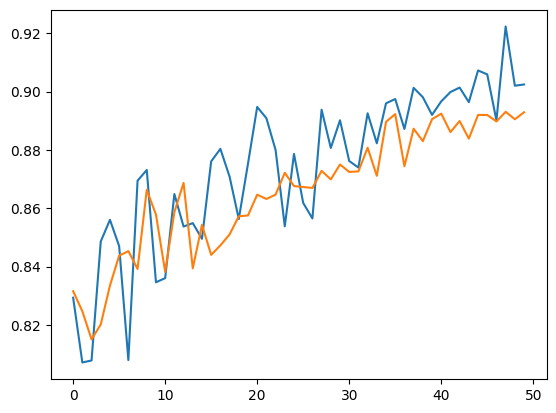

In [58]:
results, model = train(50, model.state_dict())
plt.plot(list(range(len(results["val"]["iou"]))), results["val"]["iou"])
plt.plot(list(range(len(results["train"]["iou"]))), results["train"]["iou"])
print(results["res_loss"], results["res_iou"])

100%|██████████| 219/219 [00:04<00:00, 43.98it/s]


0.17240513350865613 0.7610404894296382


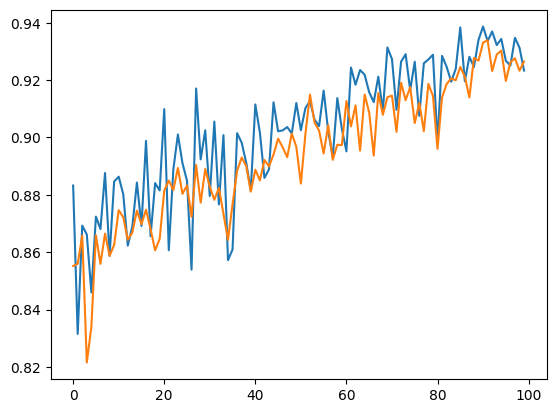

In [74]:
results, new_model = train(100, model.state_dict())
plt.plot(list(range(len(results["val"]["iou"]))), results["val"]["iou"])
plt.plot(list(range(len(results["train"]["iou"]))), results["train"]["iou"])
print(results["res_loss"], results["res_iou"])

In [77]:
torch.save(new_model.state_dict(), "road_seg_unet_solution.pt")

# Pretrained model with decoder

In [16]:
# TODO: try freezing layers

In [16]:
from torchvision.models import resnet18, resnet50, resnet101

In [17]:
import torch.nn.functional as F
import torchvision.models as models

class ResNetBlock(nn.Module):
    def __init__(self, inch, outch, activation, normalization):
        super().__init__()
        self.basic_block_1 = nn.Sequential(
            nn.Conv2d(inch, outch, 3, 1, 1),
            activation(),
            normalization(outch)
        )
        self.basic_block_2 = nn.Sequential(
            nn.Conv2d(outch, outch, 3, 1, 1),
            activation(),
            normalization(outch)
        )
        self.skip_channels = nn.Conv2d(inch, outch, 1)

    def forward(self, input):
        skip = self.skip_channels(input)
        res = self.basic_block_1(input)
        res = self.basic_block_2(res)
        return F.relu(res + skip)


In [18]:
class PretrainedModel(nn.Module):
    def __init__(self, out_channels, activation=nn.ReLU, normalization=nn.BatchNorm2d):
        super().__init__()
        self.out_channels = out_channels
        self.activation = activation
        self.normalization = normalization
        
        pretrained = resnet101(pretrained=True)
        self.upsampler = nn.Upsample(scale_factor=2.0)
        self.encoder = nn.Sequential(*list(pretrained.children())[:-3])
        self.decoder = nn.Sequential(
            nn.Sequential(
                ResNetBlock(1024, 512, activation=self.activation, normalization=self.normalization),
                self.upsampler,
            ),
            nn.Sequential(
                ResNetBlock(512, 256, activation=self.activation, normalization=self.normalization),
                self.upsampler,
            ),
            nn.Sequential(
                ResNetBlock(256, 256, activation=self.activation, normalization=self.normalization),
                self.upsampler,
            )
        )
        self.head = nn.Sequential(
            nn.Conv2d(256, self.out_channels, 1),
            self.upsampler,
        )
                        
    def forward(self, input):
        result = input
        for i, block in enumerate(self.encoder):
            result = block(result)
        for i, block in enumerate(self.decoder):
            result = block(result)
        result = self.head(result)
        return result

In [19]:
def get_trn_objects2(device):

    model = PretrainedModel(2)
    model = model.to(device)

    optimizer = torch.optim.Adam([
        {'params': model.decoder.parameters()},
        {'params': model.head.parameters()},
        {'params': model.encoder.parameters(), 'lr': 1e-4}
    ], lr=1e-4, weight_decay=1e-6)
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

    trn_augs = A.Compose([
                            A.GaussNoise(var_limit=0.1, p=0.3),
                            A.ShiftScaleRotate(shift_limit=0.09,
                                               rotate_limit=15,
                                               border_mode=0,
                                               p=0.3),
                            A.HorizontalFlip(p=0.5),
                         ])

    val_augs = A.Compose([
                         ])

    # trn_augs = A.Compose([
    #     A.OneOf([ #colors
    #         A.ColorJitter(brightness=1.0, saturation=1.0, hue=1.0, p=0.3),
    #         A.CLAHE(p=0.05),
    #         A.FancyPCA(p=0.3),
    #         A.transforms.InvertImg(p=0.05),
    #         A.transforms.RGBShift(p=0.6)
    #     ], p=0.33),
    #     A.OneOf([ #blur 
    #         A.AdvancedBlur(blur_limit=(21, 51), sigmaX_limit=(0.5, 2.5), sigmaY_limit=(0.5, 2.5), p=0.5),
    #         A.transforms.Downscale(scale_min=0.3, scale_max=0.7, p=0.5),
    #         A.Emboss(p=0.3),
    #         A.ISONoise(p=0.4)
    #     ], p=0.33),
    #     A.OneOf([ #Channels
    #         A.dropout.channel_dropout.ChannelDropout((1, 2)),
    #         A.transforms.ChannelShuffle(),
    #     ], p=0.03),
    #     A.OneOf([ #weather
    #         A.transforms.RandomFog(p=0.05),
    #         A.transforms.RandomRain(p=0.6),
    #         A.transforms.RandomShadow(p=0.05),
    #         A.transforms.RandomSunFlare(p=0.2, src_radius=100)
    #     ], p=0.11),
    #     A.OneOf([ #geometric
    #         A.geometric.rotate.Rotate(limit=40, p=0.6),
    #         A.geometric.transforms.Affine(scale=(0.7, 1.0), translate_percent=(0.05, 0.1), rotate=(-34, 34), keep_ratio=True, p=0.6),
    #         # A.crops.transforms.RandomSizedCrop(min_max_height=(int(0.6 * original_height), int(original_height)),
    #         #                                    height=original_height, width=original_width, w2h_ratio=1.0, p=0.6),
    #     ], p=0.33),
    #     A.HorizontalFlip(p=0.5)
    # ])

    trn_dataset = RoadDataset(X_train, y_train, transform, trn_augs)
    val_dataset = RoadDataset(X_val, y_val, transform, val_augs)

    trn_loader = torch.utils.data.DataLoader(trn_dataset, 
                                             batch_size=16, 
                                             shuffle=True, 
                                             pin_memory=True,
                                             num_workers=16,
                                             prefetch_factor=4)

    val_loader = torch.utils.data.DataLoader(val_dataset, 
                                             batch_size=1, 
                                             shuffle=False, 
                                             pin_memory=True,
                                             num_workers=16,
                                             prefetch_factor=2)

    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=1, 
                                              shuffle=False, 
                                              pin_memory=True,
                                              num_workers=16)
    
    loss = CustomDiceLoss()

    return {"model": model,
            "optimizer": optimizer,
            "scheduler": scheduler,
            "trn_loader": trn_loader,
            "val_loader": val_loader,
            "test_loader": test_loader,
            "loss": loss}




def train2(epochs, model=None):
    best_model = None
    best_iou = -np.inf
    device = torch.device("cuda:0")
    results = {"train": {"loss": [], "iou":[]},
               "val":   {"loss": [], "iou":[]}}
    
    trn_objects = get_trn_objects2(device)
    if model:
        trn_objects["model"].load_state_dict(model)
    for i in tqdm(range(epochs)):
        trn_loss, trn_iou = train_epoch(trn_objects["model"], 
                                        trn_objects["trn_loader"],
                                        trn_objects["loss"], 
                                        trn_objects["scheduler"], 
                                        trn_objects["optimizer"], 
                                        device,
                                        0.5)
        
        val_loss, val_iou = val_epoch(trn_objects["model"], 
                                      trn_objects["trn_loader"], 
                                      trn_objects["loss"], 
                                      trn_objects["scheduler"], 
                                      device,
                                      0.5)
        
        if val_iou > best_iou:
            best_model = copy.deepcopy(trn_objects["model"].state_dict())
            best_iou = val_iou

        results["train"]["loss"].append(trn_loss)
        results["train"]["iou"].append(trn_iou)
        results["val"]["loss"].append(val_loss)
        results["val"]["iou"].append(val_iou)
        
    trn_objects["model"].load_state_dict(best_model)
    
    results["res_loss"], results["res_iou"] = test_model(trn_objects["model"], 
                                                         trn_objects["test_loader"], 
                                                         trn_objects["loss"], 
                                                         device,
                                                         0.5)
    return results, trn_objects["model"]

100%|██████████| 219/219 [00:03<00:00, 57.84it/s]


-0.20517624132165083 0.8712971939266807


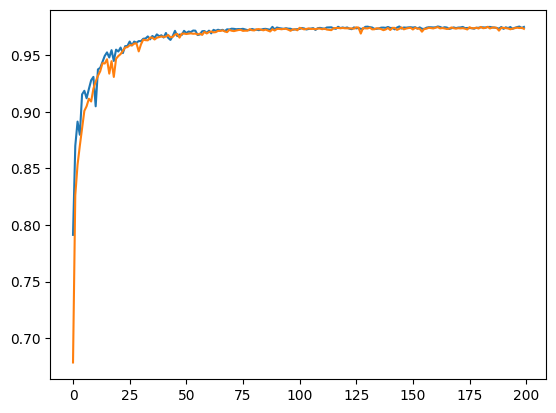

In [21]:
gc.collect()
torch.cuda.empty_cache()

results, model = train2(200)
plt.plot(list(range(len(results["val"]["iou"]))), results["val"]["iou"])
plt.plot(list(range(len(results["train"]["iou"]))), results["train"]["iou"])
print(results["res_loss"], results["res_iou"])

In [24]:
best_model = model.state_dict()

In [26]:
torch.save(best_model, "road_seg_pretrained_solution.pt")